<a href="https://colab.research.google.com/github/g-sameeksha/Myopia_Prediction_Using_CNN/blob/main/myopia_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split

In [6]:
import kagglehub

# Download dataset (this will cache it inside Colab)
path = kagglehub.dataset_download("kellysanderson/myopia-image-dataset")

print("Path to dataset files:", path)

# # Define your custom path
# custom_path = "/content/myopia_dataset"
# os.makedirs(custom_path, exist_ok=True)

# # Move dataset to custom path
# shutil.move(path, custom_path)

# print("Dataset available at:", custom_path)

# # Set BASE_DIR for further processing
# BASE_DIR = os.path.join(custom_path, "IMAGES")


Path to dataset files: /kaggle/input/myopia-image-dataset


In [2]:
BASE_DIR = "/kaggle/input/myopia-image-dataset/IMAGES"

# import os

# for root, dirs, files in os.walk(BASE_DIR):
#     print(root, "->", dirs, len(files), "files")


In [9]:
print(BASE_DIR)

/kaggle/input/myopia-image-dataset/IMAGES


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import files
# uploaded = files.upload()


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import zipfile
# import os

# with zipfile.ZipFile("myopia_image_dataset.zip", 'r') as zip_ref:
#     zip_ref.extractall("/content/myopia_dataset")

# # Define dataset base path
# BASE_DIR = "/content/myopia_dataset/IMAGES"


# Load the datasets

In [3]:
# BASE_DIR = 'C:/Users/SAMEEKSHA G/Downloads/myopia-image-dataset/IMAGES/'
BASE_DIR

'/kaggle/input/myopia-image-dataset/IMAGES'

In [15]:
# BASE_DIR = "/root/.cache/kagglehub/datasets/kellysanderson/myopia-image-dataset/versions/1/IMAGES"
#

In [3]:
# import os
# import pandas as pd
# import random
# from tqdm import tqdm

# # Initialize lists to store image paths and labels
# image_paths = []
# labels = []

# # Iterate through subdirectories
# for label in ["Myopia_images", "Normal_images"]:
#     class_dir = os.path.join(BASE_DIR, label)
#     if os.path.exists(class_dir):  # Ensure directory exists
#         all_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

#         # Select only 15% of the images
#         sample_size = max(1, int(0.15 * len(all_files)))  # Ensure at least 1 image is selected
#         sampled_files = random.sample(all_files, sample_size)  # Randomly select 15% of images

#         # Process sampled files
#         for filename in tqdm(sampled_files, desc=f"Processing {label}"):
#             image_path = os.path.join(class_dir, filename)
#             image_paths.append(image_path)
#             labels.append(label)  # Store label

# # Create DataFrame
# df = pd.DataFrame({'image': image_paths, 'label': labels})

import os
import pandas as pd
import random
from tqdm import tqdm

# Initialize lists to store image paths and labels
image_paths = []
labels = []

# Reduce sampling percentage here
SAMPLE_RATIO = 0.03  # ~7% of images per class

for label in ["Myopia_images", "Normal_images"]:
    class_dir = os.path.join(BASE_DIR, label)
    if os.path.exists(class_dir):
        all_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Select only SAMPLE_RATIO of the images
        sample_size = max(1, int(SAMPLE_RATIO * len(all_files)))
        sampled_files = random.sample(all_files, sample_size)

        # Process sampled files
        for filename in tqdm(sampled_files, desc=f"Processing {label}"):
            image_path = os.path.join(class_dir, filename)
            image_paths.append(image_path)
            labels.append(label)

# Create DataFrame
df = pd.DataFrame({'image': image_paths, 'label': labels})

print("Final dataset size:", len(df))
print(df['label'].value_counts())


Processing Normal_images: 100%|██████████| 1845/1845 [00:00<00:00, 518804.70it/s]

Final dataset size: 3743
label
Myopia_images    1898
Normal_images    1845
Name: count, dtype: int64


In [4]:
# Map labels to numeric values
label_mapping = {'Normal_images': 0, 'Myopia_images': 1}
df['label_encoded'] = df['label'].map(label_mapping)

In [5]:
# Shuffle the DataFrame to ensure balanced validation split
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

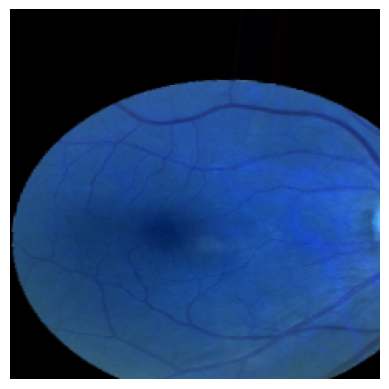

In [6]:
from PIL import Image
import matplotlib.pyplot as plt

# Use iloc for position
img_path = df['image'].iloc[0]

# Open and show
img = Image.open(img_path)
plt.axis('off')
plt.imshow(img)
plt.show()


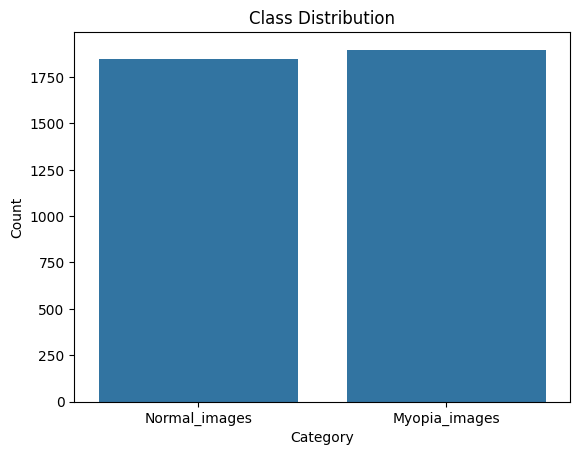

In [7]:
# Plot the count of each label
sns.countplot(x=df['label'])  # Use x= instead of passing df['label'] directly
plt.title("Class Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [8]:
# Select equal number of images from both classes
num_images = 10
df_normal = df[df['label'] == 'Normal_images'].sample(n=num_images, random_state=42)
df_myopia = df[df['label'] == 'Myopia_images'].sample(n=num_images, random_state=42)

# Combine both classes
df_balanced = pd.concat([df_normal, df_myopia]).reset_index(drop=True)

In [9]:
# Define label mapping dictionary FIRST
myopia_dict = {0: 'Normal', 1: 'Myopia'}  # Simplified labels for display

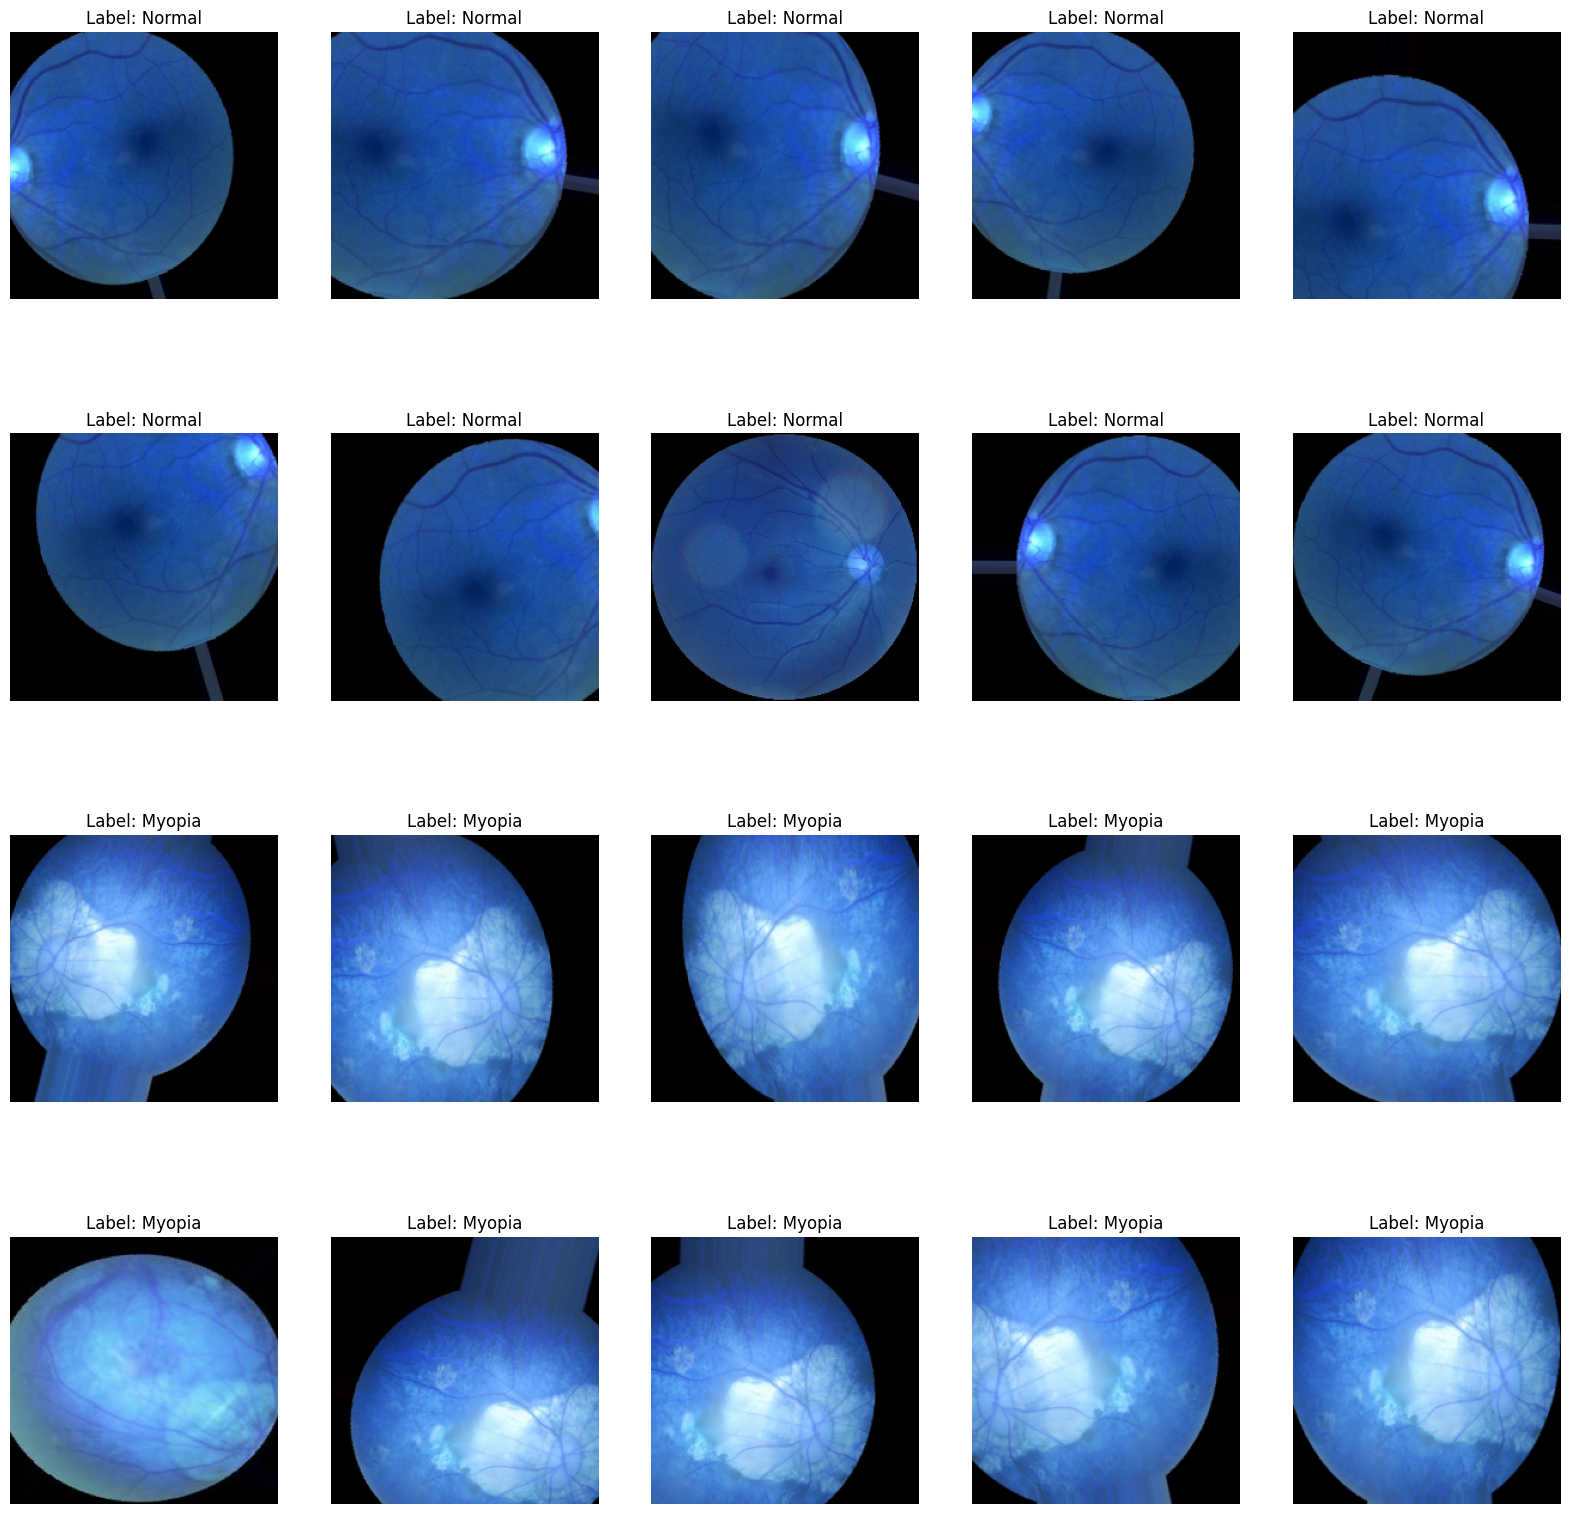

In [10]:
# Display grid of images
plt.figure(figsize=(20, 20))
for index, row in df_balanced.iterrows():
    plt.subplot(4, 5, index + 1)  # Create a 5x4 grid
    img = load_img(row['image'])  # Load image
    img = np.array(img)  # Convert to numpy array
    plt.imshow(img)
    plt.title(f"Label: {myopia_dict[row['label_encoded']]}")
    plt.axis('off')

plt.show()

In [11]:
from keras.preprocessing.image import load_img
import numpy as np
from tqdm import tqdm
from PIL import Image

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='rgb')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)  # Adjust based on Pillow version
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 3)
    return features

In [12]:
X = extract_features(df['image'])

100%|██████████| 3743/3743 [00:24<00:00, 154.53it/s]


In [13]:
X.shape

(3743, 128, 128, 3)

In [14]:
X = X/255.0  # Normalize

In [15]:
Y = np.array(df['label_encoded'])  # Use encoded labels

In [16]:
# Split into train (80%) and temporary test (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
# Split train into final train (90%) and validation (10%)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [18]:
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 2694
Validation samples: 300
Test samples: 749


In [19]:
input_shape = (128, 128, 3)

In [20]:
inputs = Input((input_shape))

# convolutional layers
conv_1 = Conv2D(128, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(512, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)

flatten = Flatten() (maxp_3)

#fully connected layers
dense = Dense(512, activation='relu') (flatten)

dropout = Dropout(0.3) (dense)

output = Dense(1, activation='sigmoid', name='myopia') (dropout)

model = Model(inputs=[inputs], outputs=[output])

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ myopia (Dense)                  │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,860,161 (201.65 MB)

 Trainable params: 52,860,161 (201.65 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Ensure 'model_visualizations' directory exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

In [23]:
# Define callbacks
checkpoint_best = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
checkpoint_last = ModelCheckpoint('last_model.keras', monitor='val_loss', save_best_only=False, mode='min')
csv_logger = CSVLogger(os.path.join(results_dir, "logs.csv"), append=True)  # Saves training logs

In [24]:
# Compile Model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Train the model with callbacks
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=64,
    epochs=5,
    validation_split=0.1,
    callbacks=[checkpoint_best, checkpoint_last, csv_logger],
    shuffle=True  # Ensure training data is shuffled each epoch
)

Epoch 1/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.6778 - loss: 1.0039 - val_accuracy: 0.9444 - val_loss: 0.1277
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 382ms/step - accuracy: 0.9593 - loss: 0.1267 - val_accuracy: 0.9444 - val_loss: 0.1387
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 565ms/step - accuracy: 0.9737 - loss: 0.0778 - val_accuracy: 0.9630 - val_loss: 0.0775
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 39s 520ms/step - accuracy: 0.9626 - loss: 0.0835 - val_accuracy: 0.9667 - val_loss: 0.0964
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 25s 636ms/step - accuracy: 0.9702 - loss: 0.0703 - val_accuracy: 0.9704 - val_loss: 0.0877


In [26]:
best_model = tf.keras.models.load_model('/content/best_model.keras')

In [27]:
# Evaluate on test set
test_loss, test_acc = best_model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.2%}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 96.26%
Test Loss: 0.0963


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.94      0.96       361
      Myopia       0.95      0.98      0.96       388

    accuracy                           0.96       749
   macro avg       0.96      0.96      0.96       749
weighted avg       0.96      0.96      0.96       749



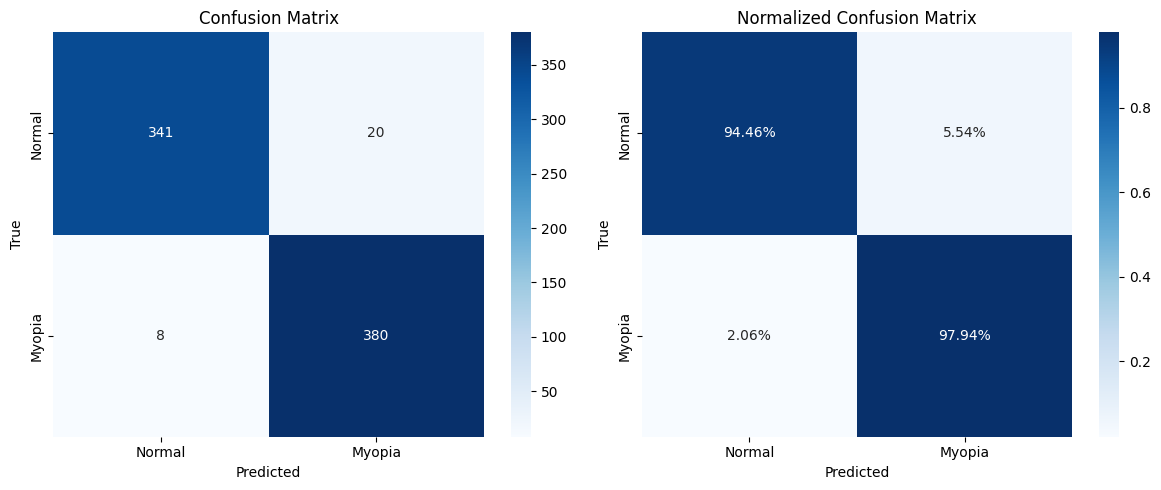

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Generate predictions
Y_pred = best_model.predict(X_test)
Y_pred_classes = (Y_pred > 0.5).astype(int)

# Classification Report
print("\nClassification Report:")
print(classification_report(Y_test, Y_pred_classes, target_names=['Normal', 'Myopia']))

# Compute confusion matrices
cm = confusion_matrix(Y_test, Y_pred_classes)
cm_normalized = confusion_matrix(Y_test, Y_pred_classes, normalize='true')

# Plot standard confusion matrix
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Myopia'], yticklabels=['Normal', 'Myopia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=['Normal', 'Myopia'], yticklabels=['Normal', 'Myopia'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

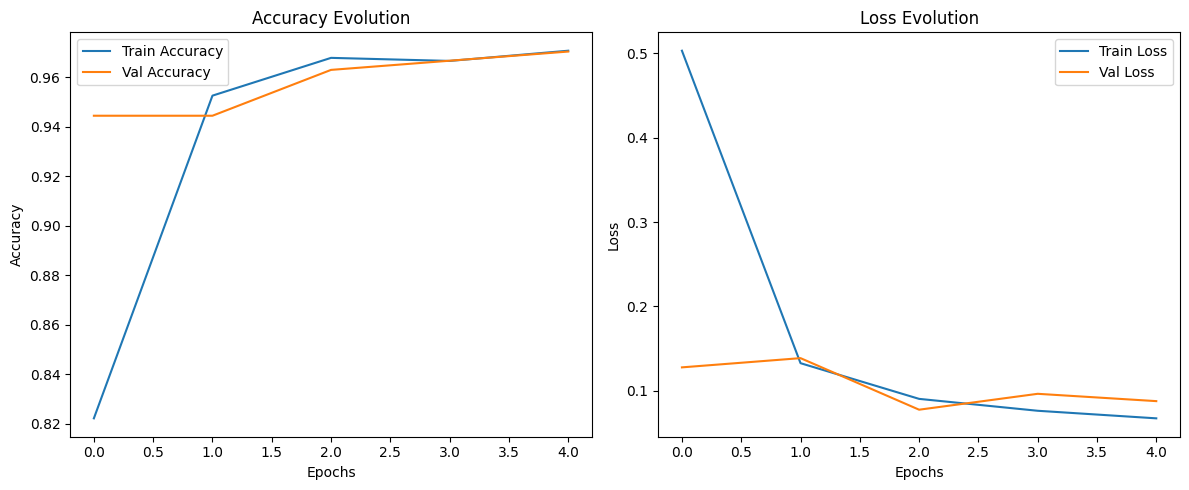

In [29]:
# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

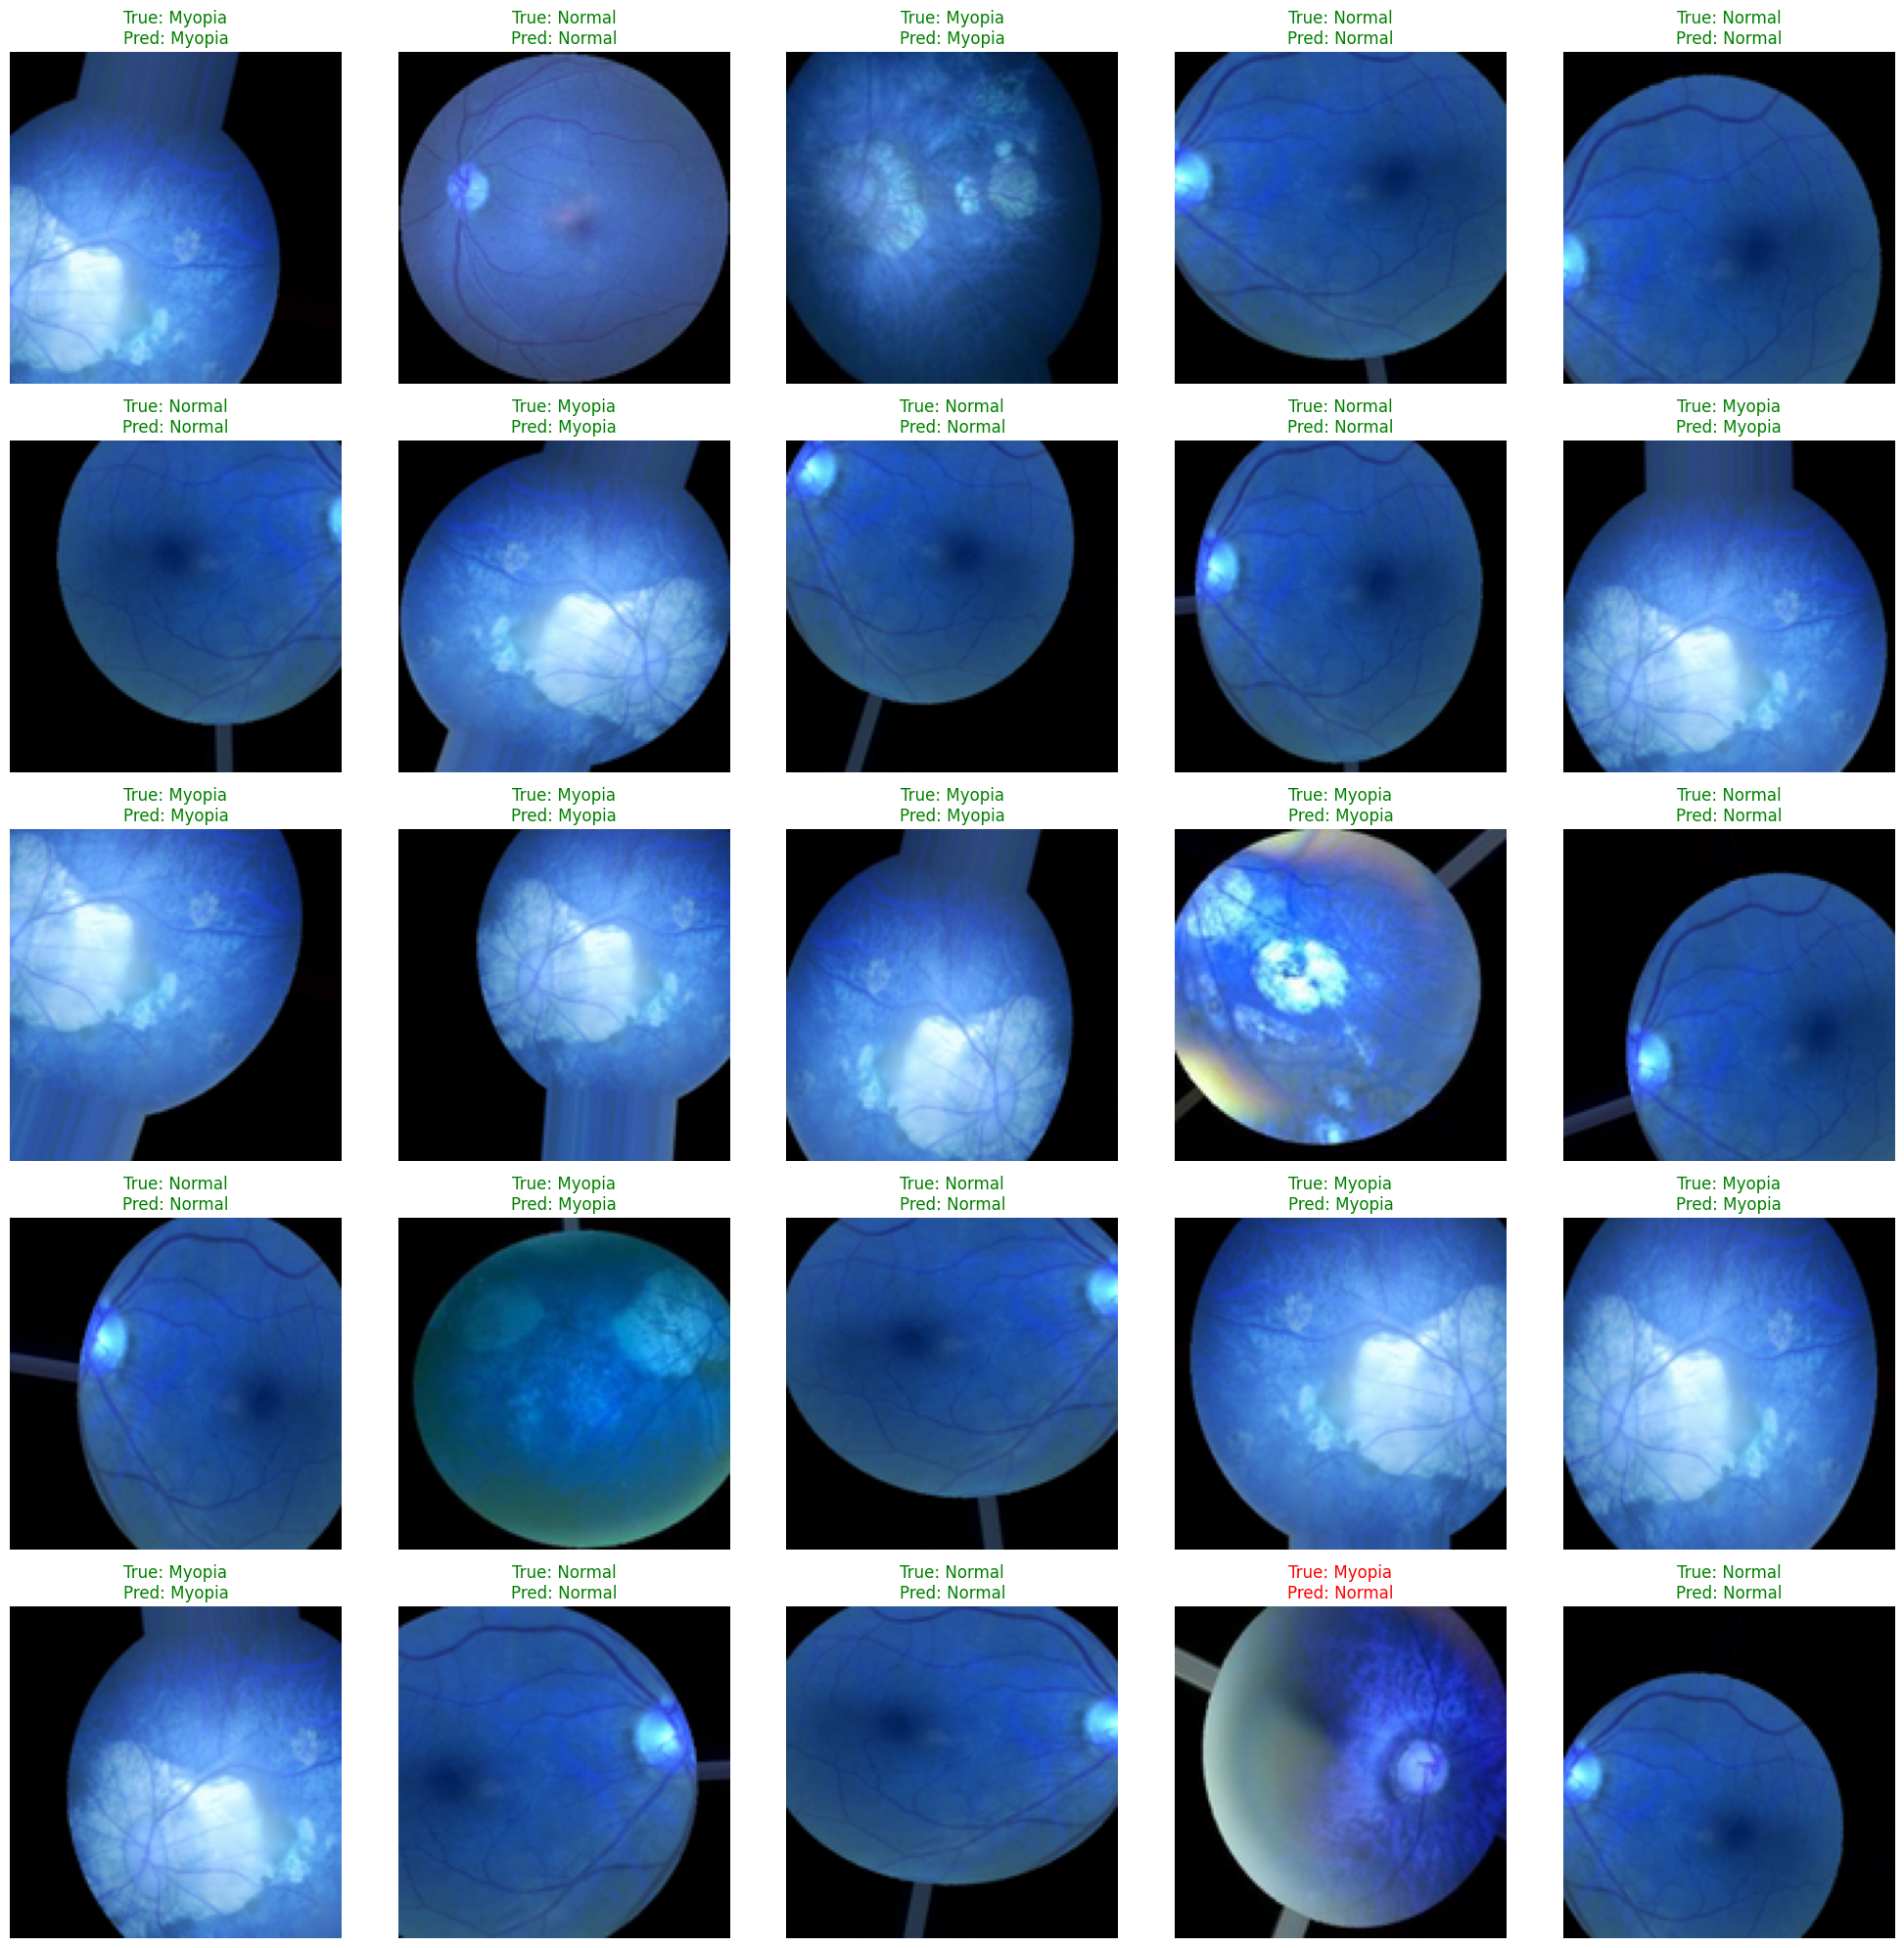

In [30]:
# Visualize test predictions
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_test[i])
    pred_label = 'Myopia' if Y_pred_classes[i][0] == 1 else 'Normal'
    true_label = 'Myopia' if Y_test[i] == 1 else 'Normal'
    color = 'green' if pred_label == true_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

Using BASE_DIR: /kaggle/input/myopia-image-dataset/IMAGES
Found 124794 files belonging to 2 classes.
Using 99836 files for training.
Found 124794 files belonging to 2 classes.
Using 24958 files for validation.
Epoch 1/5
 4445/12480 ━━━━━━━━━━━━━━━━━━━━ 5:01 38ms/step - accuracy: 0.9464 - loss: 0.1581